<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/v3_dvqc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()

He we implement d_vqc with learnable parameter and then apply decay rate and minimal learning rate.

Layer 1, Decayed Learning Rate: 0.1, Cost: 0.9029024157338771
Layer 2, Decayed Learning Rate: 0.07929623375955475, Cost: 0.9285257638956198
Layer 3, Decayed Learning Rate: 0.08175115587796067, Cost: 0.8981705973705008
Layer 4, Decayed Learning Rate: 0.06448258170897007, Cost: 0.8858391966753134
Layer 5, Decayed Learning Rate: 0.08345775514513235, Cost: 0.8950333665745607
Layer 6, Decayed Learning Rate: 0.11019885615359118, Cost: 0.9059484425742612
Layer 7, Decayed Learning Rate: 0.26814406770245314, Cost: 0.8823575081131049
Layer 8, Decayed Learning Rate: 1e-06, Cost: 0.884855301692667
Layer 9, Decayed Learning Rate: 1e-06, Cost: 0.874850535487283
Layer 10, Decayed Learning Rate: 1e-06, Cost: 0.8696631209105888
Layer 11, Decayed Learning Rate: 1.0239473308958547e-06, Cost: 0.8769711478592652
Layer 12, Decayed Learning Rate: 1e-06, Cost: 0.8815518514486372
Layer 13, Decayed Learning Rate: 1e-06, Cost: 0.8776584707990036
Layer 14, Decayed Learning Rate: 1e-06, Cost: 0.8872833068668035
La

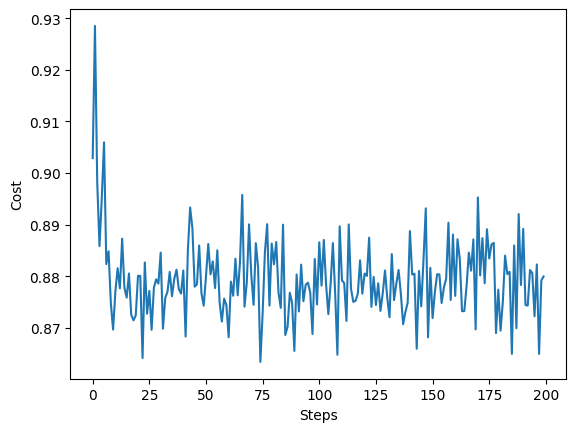

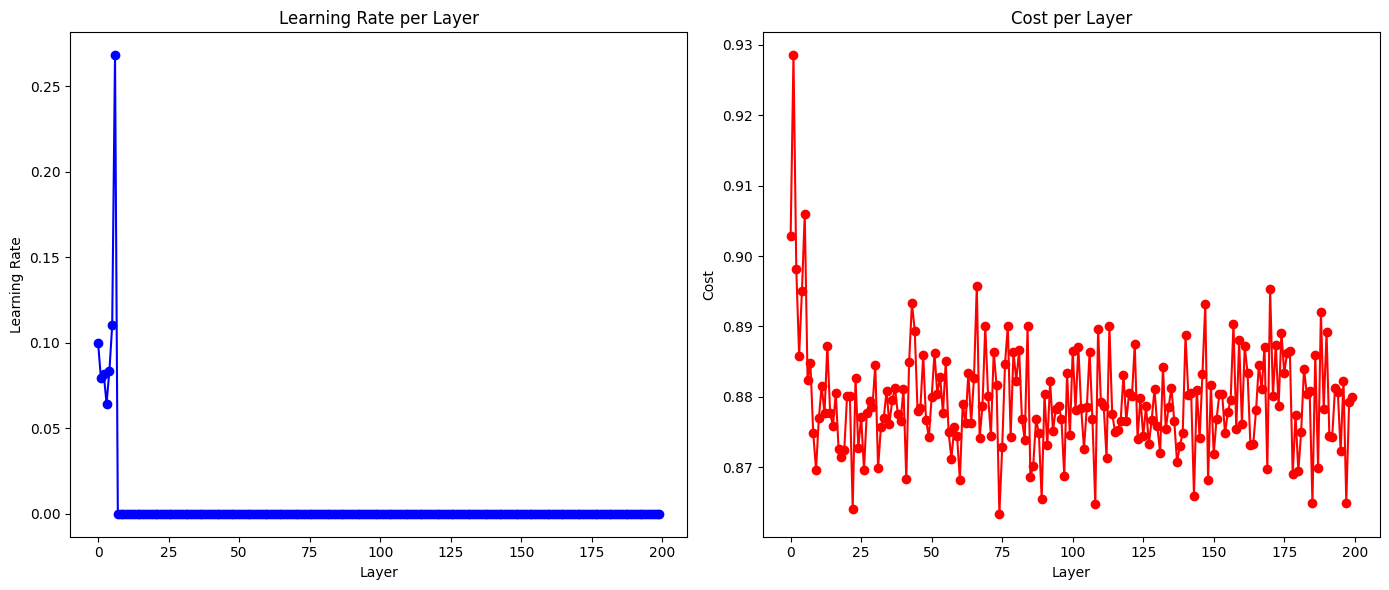

In [3]:


from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import csv
import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.step_sizes = []  # Add a list to store step sizes
    def update(self, evaluation, parameter, cost, stepsize, accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        self.step_sizes.append(stepsize)  # Store the step size
    def save_to_csv(self, filename='optimizer_log_dun.csv'):
        """Save evaluations, costs, and step sizes to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost', 'Step Size'])
            for evaluation, cost, step_size in zip(self.evaluations, self.costs, self.step_sizes):
                writer.writerow([evaluation, cost, step_size])
        print(f"Optimizer log saved to {filename}")

# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = GradientDescent(maxiter=1)

initial_lr = 0.1  # Initial learning rate
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546,initial_lr])

def objective_function(params):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""

    """Cost function for variational parameters and learning rate.

    Args:
        params (list): List containing variational parameters followed by the learning rate.

    Returns:
        float: The cost of the given parameters.
    """

    #Split params into variational parameters and learning rate
    variational = params[:-1]
    learning_rate = params[-1]

    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
# Define a learning rate decay function
def learning_rate_decay(learning_rate, decay_rate=0.05, layer=1, min_lr=1e-6):
    """Applies exponential decay to the learning rate with a lower bound."""
    decayed_lr = learning_rate * np.exp(-decay_rate * layer)
    return max(decayed_lr, min_lr)  # Ensure learning rate does not go below min_lr

# Deep Unfolding Training
num_layers = 200  # Number of layers (iterations) for deep unfolding
opt_var = initial_point

'''
for layer in range(num_layers):

    result = optimizer.minimize(objective_function, opt_var)
    # Log the updated parameters and cost
    current_lr = opt_var[-1]  # Extract the learning rate from the parameters
    print(f"Layer {layer + 1}, Learning Rate: {current_lr}, Cost: {result.fun}")

    # Reinitialize optimizer with the current learning rate
    optimizer = GradientDescent(maxiter=1, learning_rate=current_lr)


    opt_var = result.x  # Update parameters for the next layer
    #log.update(layer, opt_var, result.fun)
    log.update(layer, opt_var, result.fun, current_lr, None)

    # Print the cost at each iteration
    print(f"Cost after layer {layer + 1}: {result.fun}")
'''
# Initialize lists to store costs
costs = []
for layer in range(num_layers):
    # Extract current learning rate from opt_var (last element)
    current_lr = opt_var[-1]

    # Apply learning rate decay for the current layer
    decayed_lr = learning_rate_decay(current_lr, decay_rate=0.05, layer=layer)

    # Reassign the decayed learning rate back into the opt_var parameter array
    opt_var[-1] = decayed_lr

    # Reinitialize the optimizer with the dynamically decayed learning rate
    optimizer = GradientDescent(maxiter=1, learning_rate=decayed_lr)

    # Perform optimization step
    result = optimizer.minimize(objective_function, opt_var)

    # Update opt_var to reflect the new optimized variational parameters and learning rate
    opt_var = result.x
     # Append the cost to the list
    costs.append(result.fun)

    # Log the updated parameters and cost
    log.update(layer, opt_var, result.fun, decayed_lr, None)

    # Print the current learning rate and cost at each layer
    print(f"Layer {layer + 1}, Decayed Learning Rate: {decayed_lr}, Cost: {result.fun}")


# Final optimized value and cost
opt_value = log.costs[-1]
opt_var = log.parameters[-1]
# After the optimization loop
log.save_to_csv('optimizer_log_dun.csv')
#result = optimizer.minimize(objective_function, initial_point)

#opt_var = result.x
#opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

# Plot learning rate per layer from log.step_sizes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_layers), log.step_sizes, color='blue', marker='o')
plt.xlabel('Layer')
plt.ylabel('Learning Rate')
plt.title('Learning Rate per Layer')

# Plot cost per layer
plt.subplot(1, 2, 2)
plt.plot(range(num_layers), costs, color='red', marker='o')
plt.xlabel('Layer')
plt.ylabel('Cost')
plt.title('Cost per Layer')

plt.tight_layout()
plt.show()